In [1]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
                                transforms.Resize((28, 28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5))
                                ])
training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

training_loader = DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [3]:
def im_convert(ten):
    image =ten.clone().detach().numpy()
    image = image.transpose(1,2,0)# Original (color, width, height) new (width, height, color)
    print(image.shape)
    image = image * np.array((0.5,)) + np.array((0.5,))
    image = image.clip(0, 1)
    return image


(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


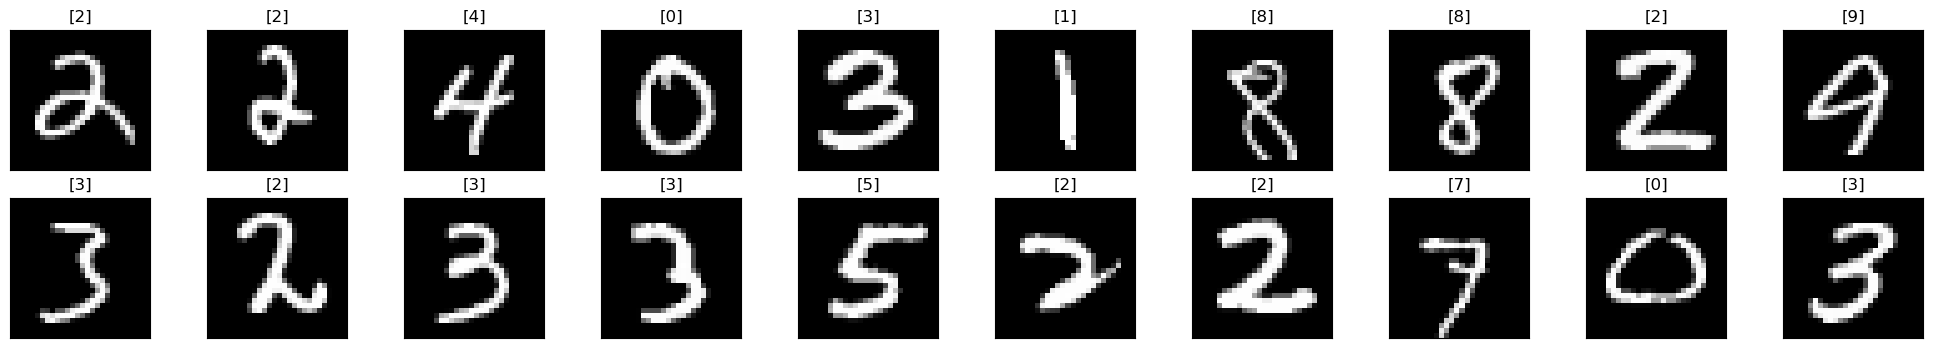

In [4]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]), cmap='gray')
    ax.set_title([(labels[idx].item())])


In [5]:
from torch import nn 
import torch.nn.functional as F
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out) -> None:
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x 
    
         

In [6]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [8]:
# epochs = 18
# running_loss_history = []
# running_currects_history = []

# for e in range(epochs):
#     running_loss = 0.0
#     running_corrects = 0.0
#     for inputs, labels in training_loader:
#         inputs = inputs.view(inputs.shape[0], -1)
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
        
#         optimizer.zero_grad()
#         loss.backward()

#         optimizer.step()

#         _, preds = torch.max(outputs, 1)
#         running_loss += loss.item()
#         running_corrects +=torch.sum(preds == labels.data)
#     else: 
#         epoch_loss = running_loss/len(training_loader)
#         epoch_acc = running_corrects.float()/len(training_loader)
#         running_loss_history.append(epoch_loss)
#         running_currects_history.append(epoch_acc)
#         print('training loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc.item()))

In [9]:
# Check for CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Choose the appropriate GPU device
else:
    device = torch.device("cpu")     # Use CPU if GPU is not available

# Assuming you've defined and initialized model, criterion, and optimizer
model = model.to(device)  # Move the model to the GPU or CPU

epochs = 18
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []


for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    model.train()  # Set the model to training mode

    for inputs, labels in training_loader:
        inputs = inputs.view(inputs.shape[0], -1)
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU or CPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            model.eval()
            for val_inputs, val_labels in validation_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)


        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('Epoch [{}/{}], Training Loss: {:.4f}, Acc: {:.4f}'
              .format(e + 1, epochs, epoch_loss, epoch_acc.item()))
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Acc: {:.4f}'
              .format(e + 1, epochs, val_epoch_loss, val_epoch_acc.item()))


# You can add a validation loop here to evaluate the model's performance on a validation dataset after each epoch


Epoch [1/18], Training Loss: 0.9795, Acc: 75.1667
Epoch [1/18], Validation Loss: 0.4416, Validation Acc: 88.3000
Epoch [2/18], Training Loss: 0.3884, Acc: 89.1050
Epoch [2/18], Validation Loss: 0.3257, Validation Acc: 90.7900
Epoch [3/18], Training Loss: 0.3221, Acc: 90.6533
Epoch [3/18], Validation Loss: 0.2868, Validation Acc: 91.7000
Epoch [4/18], Training Loss: 0.2886, Acc: 91.5983
Epoch [4/18], Validation Loss: 0.2653, Validation Acc: 92.4200
Epoch [5/18], Training Loss: 0.2633, Acc: 92.2750
Epoch [5/18], Validation Loss: 0.2422, Validation Acc: 92.9600
Epoch [6/18], Training Loss: 0.2422, Acc: 92.9367
Epoch [6/18], Validation Loss: 0.2297, Validation Acc: 93.3200
Epoch [7/18], Training Loss: 0.2244, Acc: 93.4817
Epoch [7/18], Validation Loss: 0.2095, Validation Acc: 94.0700
Epoch [8/18], Training Loss: 0.2083, Acc: 93.9333
Epoch [8/18], Validation Loss: 0.1993, Validation Acc: 94.2100
Epoch [9/18], Training Loss: 0.1942, Acc: 94.3767
Epoch [9/18], Validation Loss: 0.1868, Validat

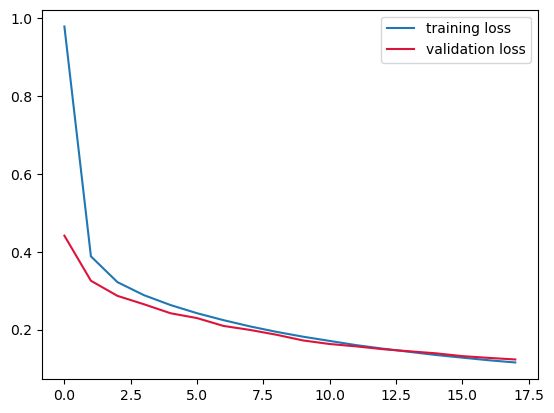

In [10]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label = "validation loss", c="crimson")
plt.legend()

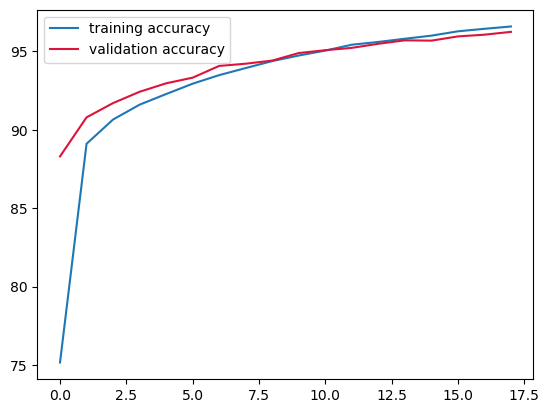

In [11]:
plt.plot([c.cpu().detach().numpy() for c in running_corrects_history], label='training accuracy')
plt.plot([c.cpu().detach().numpy() for c in val_running_corrects_history], label = "validation accuracy", c="crimson")
plt.legend()

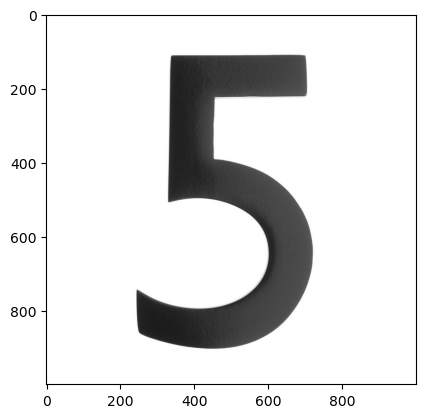

In [12]:
url_for_test_image = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
import requests
from PIL import Image, ImageOps
response = requests.get(url_for_test_image, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

(28, 28, 1)


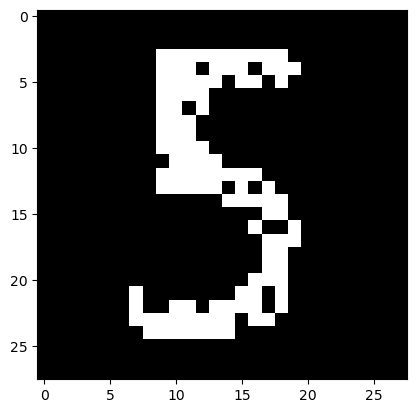

In [13]:
img = ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img), cmap='gray')

In [28]:
img = img.view(img.shape[0], -1).to(device)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5
